[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [24]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("api key to be used here")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

In [25]:
_set_env("Langsmith api key to be used here")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [26]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# Creating a short conversation to explore ocean animals
dialogue_log = [
    AIMessage(content="Hey there! You mentioned an interest in marine life?", name="Bot"),
    HumanMessage(content="Yes! I know a bit about dolphins, but what else should I read about?", name="Lance")
]

# Displaying the structured messages
for msg in dialogue_log:
    msg.pretty_print()


================================== Ai Message ==================================
Name: Bot

Hey there! You mentioned an interest in marine life?
================================ Human Message =================================
Name: Lance

Yes! I know a bit about dolphins, but what else should I read about?


Recall we can pass them to a chat model.

In [27]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")


We can run our chat model in a simple graph with `MessagesState`.

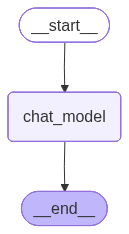

In [28]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
import os

# ==========================
# Option 1: Set API key as environment variable
# Replace the string below with your actual API key
os.environ["OPENAI_API_KEY"] = "api key to be used here"
# ==========================


# If using Option 1, initialize normally:
llm = ChatOpenAI(model="gpt-4o-mini")

# Node function
def chat_model_node(state: MessagesState):
    # Invokes the LLM with the current messages
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))


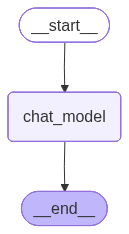

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


In [33]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
import os

# ==========================
# Add your API key here
os.environ["OPENAI_API_KEY"] = "api key to be used here"
# ==========================

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Node function
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Invoke the graph with messages
messages = [{"role": "user", "content": "Hello, how are you?"}]
output = graph.invoke({'messages': messages})

# Print each message neatly
for m in output['messages']:
    m.pretty_print()
# ==========================


## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

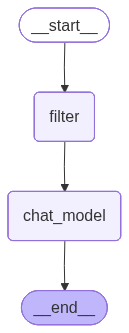

================================ Human Message =================================

Tell me a fun fact about whales.
================================ Human Message =================================

Can you summarize it in one line?
================================== Ai Message ==================================

Humpback whales are known for their long, complex songs, which can last up to 20 minutes and can be heard over vast ocean distances!


In [34]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import RemoveMessage

# ==========================
# Initialize the LLM
# Replace the string below with your actual OpenAI API key
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node 1: Filter messages to keep only the 2 most recent
def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

# Node 2: Send messages to the LLM
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Invoke the graph with sample messages
messages = [
    {"role": "user", "content": "Hello, how are you?"},
    {"role": "user", "content": "Tell me a fun fact about whales."},
    {"role": "user", "content": "Can you summarize it in one line?"}
]

output = graph.invoke({'messages': messages})

# Print the model responses neatly
for m in output['messages']:
    m.pretty_print()
# ==========================


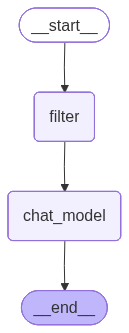

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating groups of ocean mammals you might want to explore:

1. **Dolphins**: These highly intelligent creatures belong to the family Delphinidae. Common species include the bottlenose dolphin and the common dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and with different tooth shapes, porpoises are part of the family Phocoenidae. The harbour porpoise is a well-known species.

3. **Sea Lions**: These pinnipeds (flipper-footed) are known for their vocalizations and playful behavior. The California sea lion is a prominent species often seen in coas

In [35]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import RemoveMessage, AIMessage, HumanMessage

# ==========================
# Initialize the LLM with your API key
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node 1: Filter messages to keep only the 2 most recent
def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

# Node 2: Send messages to the LLM
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Invoke the graph
output = graph.invoke({'messages': messages})

# Print model responses neatly
for m in output['messages']:
    m.pretty_print()
# ==========================


## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

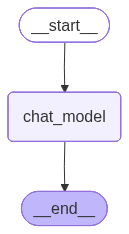

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

If you're interested in learning about marine life beyond whales, here are some fascinating topics and species to explore:

1. **Dolphins**: Known for their intelligence and social behavior, dolphins are closely related to whales and have complex communication systems.

2. **Sharks**: These apex predators play crucial roles in marine ecosystems. Learn about their different species, behaviors, and importance in ocean health

In [38]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage

# ==========================
# Initialize the LLM with your API key
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node: Only send the last message to the model
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Invoke the graph
output = graph.invoke({'messages': messages})

# Print the model responses neatly
for m in output['messages']:
    m.pretty_print()
# ==========================


Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

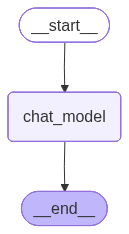

================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!
================================== Ai Message ==================================

Narwhals (Monodon monoceros) are unique marine mammals known for their long, spiral tusks, which are actually elongated teeth. They are often referred to as the "unicorns of the sea" due to this striking feature. Here are some interesting facts about narwhals:

1. **Habitat**: Narwhals are primarily found in the Arctic waters, particularly in the North Atlantic and Arctic Oceans. They are known t

================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!
================================== Ai Message ==================================

Narwhals (Monodon monoceros) are unique marine mammals known for their long, spiral tusks, which are actually elongated teeth. They are often referred to as the "unicorns of the sea" due to this striking feature. Here are some interesting facts about narwhals:

1. **Habitat**: Narwhals are primarily found in the Arctic waters, particularly in the North Atlantic and Arctic Oceans. They are known to inhabit deep, ice-covered waters, and they often migrate seasonally, moving to open waters as the ice thaws.

2. **Tusks**: The tusk of a narwhal is typically found in males but can also appear in females. It can grow as long as 10 feet

In [40]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage

# ==========================
# Initialize the LLM with your API key
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node: Only send the last message to the model
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Initialize output variable
output = None

# Function to interact: append last AI response + new user input
def chat_with_graph(user_text):
    global output  # Declare first
    # Append last AI response if exists
    if output and output['messages']:
        messages.append(output['messages'][-1])
    # Append new user message
    messages.append(HumanMessage(user_text, name="Lance"))

    # Trim messages to last 4 to avoid long history
    messages_trimmed = messages[-4:]

    # Invoke graph
    output = graph.invoke({'messages': messages_trimmed})

    # Print AI responses
    for m in output['messages']:
        m.pretty_print()

# ==========================
# Example usage
chat_with_graph("Tell me more about Narwhals!")
chat_with_graph("And what about dolphins?")
# ==========================


In [ ]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

In [ ]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

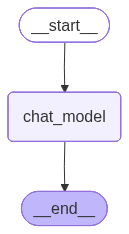

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, here are some fascinating ocean mammals you might want to explore:

1. **Dolphins** - Known for their intelligence and playful behavior, dolphins are social animals often found in pods.

2. **Porpoises** - Similar to dolphins but generally smaller, porpoises have a more rounded snout and are known for being shy.

3. **Sea Lions** - These pinnipeds are known for their external ear flaps and can often 

In [41]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, trim_messages

# Initialize LLM with API key
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")

# Node: Trim messages by token count before sending to LLM
def chat_model_node(state: MessagesState):
    messages_trimmed = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o-mini"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages_trimmed)]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Invoke the graph with trimmed messages
output = graph.invoke({'messages': messages})

# Print AI responses neatly
for m in output['messages']:
    m.pretty_print()


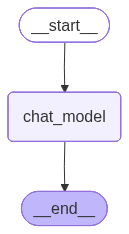

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, here are some fascinating ocean mammals you might want to explore:

1. **Dolphins** - Known for their intelligence and playful behavior, dolphins are social animals often found in pods.

2. **Porpoises** - Similar to dolphins but generally smaller, porpoises have a more rounded snout and are known for being shy.

3. **Sea Lions** - These pinnipeds are known for their external ear flaps and can often 

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, here are some fascinating ocean mammals you might want to explore:

1. **Dolphins** - Known for their intelligence and playful behavior, dolphins are social animals often found in pods.

2. **Porpoises** - Similar to dolphins but generally smaller, porpoises have a more rounded snout and are known for being shy.

3. **Sea Lions** - These pinnipeds are known for their external ear flaps and can often 

In [43]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, trim_messages

# ==========================
# Initialize LLM with your API key
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node: Trim messages by token count before sending to LLM
def chat_model_node(state: MessagesState):
    messages_trimmed = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o-mini"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages_trimmed)]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Function to continue conversation
def chat(user_text):
    global output  # declare global so we can store last AI output
    # Append last AI response if exists
    if 'output' in globals() and output and output['messages']:
        messages.append(output['messages'][-1])
    # Append new user message
    messages.append(HumanMessage(user_text, name="Lance"))

    # Trim messages to last few tokens automatically via chat_model_node
    output = graph.invoke({'messages': messages})

    # Print AI responses
    for m in output['messages']:
        m.pretty_print()

# ==========================
# Example usage
chat("Tell me where Orcas live!")
chat("And what about dolphins?")


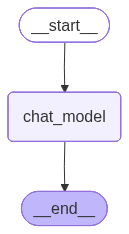

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, or killer whales, are found in oceans all around the world. They inhabit both cold and warm waters, making them one of the most widely distributed marine mammals. Typically, they are commonly sighted in coastal areas, but they can also be found in deep oceanic waters. Major populations are known to

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, or killer whales, are found in oceans all around the world. They inhabit both cold and warm waters, making them one of the most widely distributed marine mammals. Typically, they are commonly sighted in coastal areas, but they can also be found in deep oceanic waters. Major populations are known to

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, or killer whales, are found in oceans all around the world. They inhabit both cold and warm waters, making them one of the most widely distributed marine mammals. Typically, they are commonly sighted in coastal areas, but they can also be found in deep oceanic waters. Major populations are known to

In [44]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, trim_messages

# ==========================
# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node: Trim messages before sending to LLM
def chat_model_node(state: MessagesState):
    trimmed = trim_messages(
        state["messages"],
        max_tokens=100,                     # Maximum tokens to keep
        strategy="last",                    # Keep recent messages
        token_counter=ChatOpenAI(model="gpt-4o-mini"),  # Token counter
        allow_partial=False                  # Only full messages
    )
    return {"messages": [llm.invoke(trimmed)]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Initialize output variable
output = None

# Function to continue conversation
def chat(user_text):
    global output
    # Append last AI response if exists
    if output and output['messages']:
        messages.append(output['messages'][-1])
    # Append new user message
    messages.append(HumanMessage(user_text, name="Lance"))

    # Invoke the graph
    output = graph.invoke({'messages': messages})

    # Print AI responses
    for m in output['messages']:
        m.pretty_print()

# ==========================
# Example usage
chat("Tell me where Orcas live!")
chat("And what about dolphins?")
chat("Can you give me a fun fact about Narwhals?")


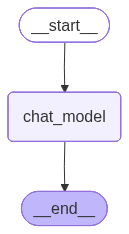

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, also known as killer whales, are found in oceans all around the world. They inhabit a variety of environments, including coastal waters, open oceans, and even some river systems. They are most commonly found in colder waters, such as the Arctic and Antarctic regions, but they can also be seen in wa

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, also known as killer whales, are found in oceans all around the world. They inhabit a variety of environments, including coastal waters, open oceans, and even some river systems. They are most commonly found in colder waters, such as the Arctic and Antarctic regions, but they can also be seen in wa

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================ Human Message =================================
Name: Lance

Tell me where Orcas live!
================================== Ai Message ==================================

Orcas, also known as killer whales, are found in oceans all around the world. They inhabit a variety of environments, including coastal waters, open oceans, and even some river systems. They are most commonly found in colder waters, such as the Arctic and Antarctic regions, but they can also be seen in wa

In [46]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, trim_messages

# ==========================
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key="api key to be used here")
# ==========================

# Node: Trim messages before sending to LLM
def chat_model_node(state: MessagesState):
    trimmed = trim_messages(
        state["messages"],
        max_tokens=100,                     # Maximum tokens to keep
        strategy="last",                    # Keep recent messages
        token_counter=ChatOpenAI(model="gpt-4o-mini"),  # Token counter
        allow_partial=False                  # Only full messages
    )
    return {"messages": [llm.invoke(trimmed)]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# ==========================
# Pre-populated conversation
messages = [
    AIMessage("Hi.", name="Bot", id="1"),
    HumanMessage("Hi.", name="Lance", id="2"),
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4")
]

# Initialize output variable
output = None

# Function to continue conversation
def chat(user_text):
    global output
    # Append last AI response if exists
    if output and output['messages']:
        messages.append(output['messages'][-1])
    # Append new user message
    messages.append(HumanMessage(user_text, name="Lance"))

    # Invoke the graph with trimming applied inside the node
    output = graph.invoke({'messages': messages})

    # Print AI responses
    for m in output['messages']:
        m.pretty_print()

# ==========================
# Example usage
chat("Tell me where Orcas live!")
chat("And what about dolphins?")
chat("Can you give me a fun fact about Narwhals?")


Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r